In [2]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import wandb
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Definition of Renyi Divergence
class RenyiDivergence(nn.Module):
    def __init__(self, alpha=0.5):
        super(RenyiDivergence, self).__init__()
        self.alpha = alpha
    def forward(self, input_logits, target_logits):
        q = torch.softmax(input_logits,dim=1)
        p = torch.softmax(target_logits,dim=1)
        
        if self.alpha == 1: # KL Divergence
            return torch.sum(p * torch.log(p/q),dim=1).mean()
        
        return 1/(self.alpha-1) * torch.log(torch.sum(torch.pow(p,self.alpha)*torch.pow(q,1-self.alpha),dim=1)).mean()

In [4]:
# Test
x = torch.tensor([[2/3,1/3,1/3],[2/3,1/3,1/3]],requires_grad=True)
y = torch.tensor([[1/3,2/3,1/3],[1/3,2/3,1/3]])
output = RenyiDivergence(alpha=1)(x,y)
print(output)
output.backward()
print(x.grad)

tensor(0.0388, grad_fn=<MeanBackward0>)
tensor([[ 5.8253e-02, -5.8253e-02, -8.7767e-09],
        [ 5.8253e-02, -5.8253e-02, -8.7767e-09]])


In [5]:
# Example of divergence being infinity
#y = torch.tensor([[-0.7753, -0.7236, -0.6072, -0.8284, -0.8085, -0.8923, -0.6853, -0.8315,-0.8302, -0.7934]])
#x = torch.tensor([[-9.7151e+00, -7.6585e+00, -7.3228e+00, -7.9473e-08, -1.0569e+01,-6.7095e+00, -1.1969e+01, -7.1102e+00, -5.1660e+00, -6.2902e+00]])

In [6]:
## Preparation for plot creation
Q = torch.tensor([[1/3,2/3]])
Q = torch.log(Q)
lists = []
for alpha in [0.5,1,2,10]:
    list = []
    for p in range(501):
        P = torch.tensor([[p/500,1-p/500]])
        P = torch.log(P)
        divergence = RenyiDivergence(alpha=alpha)(Q,P)
        list.append(divergence)
    lists.append(list)
    
P = torch.tensor([[1/3,2/3]])
P = torch.log(P)
lists_2 = []
for alpha in [0.5,1,2,10]:
    list = []
    for q in range(501):
        Q = torch.tensor([[q/500,1-q/500]])
        Q = torch.log(Q)
        divergence = RenyiDivergence(alpha=alpha)(Q,P)
        list.append(divergence)
    lists_2.append(list)

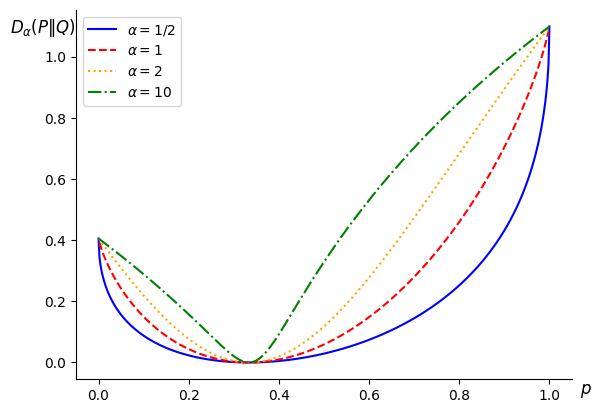

In [7]:
## Ploting
fig, ax = plt.subplots()

ax.plot(np.array(range(501)) / 500, np.transpose(np.array(lists[0])), color='blue', linestyle='-',
        label=r'$\alpha = 1/2$')
ax.plot(np.array(range(501)) / 500, np.transpose(np.array(lists[1])), color='red', linestyle='--',
        label=r'$\alpha = 1$')
ax.plot(np.array(range(501)) / 500, np.transpose(np.array(lists[2])), color='orange', linestyle=':',
        label=r'$\alpha = 2$')
ax.plot(np.array(range(501)) / 500, np.transpose(np.array(lists[3])), color='green', linestyle='-.',
        label=r'$\alpha = 10$')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.annotate(r'$p$', xy=(1.05, 0), xytext=(10, -20),
            textcoords='offset points', ha='center', va='center', fontsize=12)

ax.annotate(r'$D_\alpha(P \| Q)$', xy=(0, 1.05), xytext=(-40, 10),
            textcoords='offset points', ha='center', va='center', fontsize=12)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.legend()

fig.savefig('Renyi_Divergence.png')

plt.show()


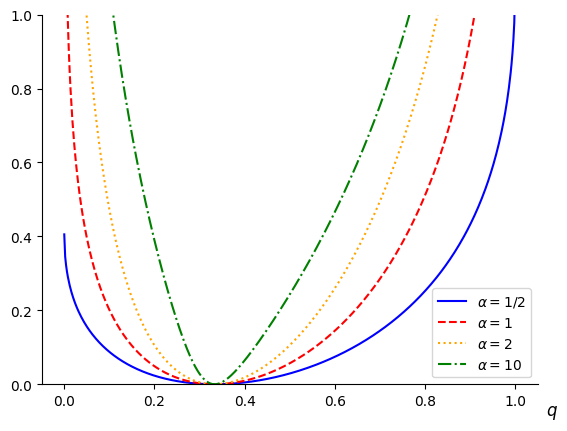

In [8]:
fig, ax = plt.subplots()

ax.plot(np.array(range(501)) / 500, np.transpose(np.array(lists_2[0])), color='blue', linestyle='-', label=r'$\alpha = 1/2$')
ax.plot(np.array(range(501)) / 500, np.transpose(np.array(lists_2[1])), color='red', linestyle='--', label=r'$\alpha = 1$')
ax.plot(np.array(range(501)) / 500, np.transpose(np.array(lists_2[2])), color='orange', linestyle=':', label=r'$\alpha = 2$')
ax.plot(np.array(range(501)) / 500, np.transpose(np.array(lists_2[3])), color='green', linestyle='-.', label=r'$\alpha = 10$')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.annotate(r'$q$', xy=(1.05, 0), xytext=(10, -20), 
            textcoords='offset points', ha='center', va='center', fontsize=12)

ax.annotate(r'$D_\alpha(P \| Q)$', xy=(0, 5.45), xytext=(-40, 10), 
            textcoords='offset points', ha='center', va='center', fontsize=12)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.ylim(0,1)

ax.legend()

fig.savefig('Renyi_Divergence_2.png')

plt.show()

In [4]:
# Definition of Decoupled Knowledge Distillation
class DKD(nn.Module):
    def __init__(self, alpha=1,beta=1):
        super(DKD, self).__init__()
        self.alpha = alpha
        self.beta = beta
    def forward(self, input_logits, target_logits,true_labels):
        target_mask = torch.zeros_like(target_logits).scatter_(1, true_labels.unsqueeze(1), 1).bool()
        
        p_t = torch.exp(torch.sum(target_logits*target_mask,dim=1,keepdim=True))/torch.sum(torch.exp(target_logits),dim=1,keepdim=True)
        q_t = torch.exp(torch.sum(input_logits*target_mask,dim=1,keepdim=True))/torch.sum(torch.exp(input_logits),dim=1,keepdim=True)
        
        b = torch.cat([p_t,1-p_t],dim=1)+0.000001
        d = torch.cat([q_t,1-q_t],dim=1)+0.000001
        
        tckd = torch.sum(b * torch.log(b / d), dim=1)
        
        p_hat = F.softmax(target_logits-1000.0*target_mask,dim=1)+0.000001*target_mask
        q_hat = F.softmax(input_logits-1000.0*target_mask,dim=1)+0.000001*target_mask
        
        nckd = torch.sum(p_hat * torch.log(p_hat/q_hat),dim=1)
        
        #return torch.mean(tckd + (1-p_t) * nckd) ## If we plug this in we get KD
        
        return torch.mean(self.alpha * tckd + self.beta * nckd)

In [69]:
# Test
true_labels = torch.tensor([1,1])
x = torch.tensor([[2/3,1/3,1/3],[2/3,1/3,1/3]],requires_grad=True)
y = torch.tensor([[1/3,2/3,1/3],[1/3,2/3,1/3]])
output = DKD(alpha=1,beta=1)(x,y,true_labels)
print(output)
output.backward()
print(x.grad)

tensor(0.0445, grad_fn=<MeanBackward0>)
tensor([[ 0.0752, -0.0583, -0.0170],
        [ 0.0752, -0.0583, -0.0170]])


In [83]:
# Test
true_labels = torch.tensor([1, 2])
x = torch.tensor([[0.9513, -0.0333, -0.2298], [-1.3912, -0.6202, -0.1879]], requires_grad=True)
y = torch.tensor([[-6.6371, 19.0506, -4.3150], [-5.8639, -4.1558, -1.3362]])
output = DKD(alpha=0.5, beta=0.5)(x, y, true_labels)
print(output)
output.backward()
print(x.grad)

tensor(0.7610, grad_fn=<MeanBackward0>)
tensor([[ 0.3177, -0.1944, -0.1233],
        [ 0.0740,  0.0313, -0.1053]])


In [5]:
# Definition of Generalized Decoupled Knowledge Distillation
class GDKD(nn.Module):
    def __init__(self, alpha=0.5,delta=1,gamma=1):
        super(GDKD, self).__init__()
        self.alpha = alpha
        self.delta = delta
        self.gamma = gamma
    def forward(self, input_logits, target_logits,true_labels):
        if self.alpha == 1:
            return DKD(alpha=self.delta,beta=self.gamma)(input_logits,target_logits,true_labels)
        
        target_mask = torch.zeros_like(target_logits).scatter_(1, true_labels.unsqueeze(1), 1).bool()
        
        p_t = torch.exp(torch.sum(target_logits*target_mask,dim=1,keepdim=True))/torch.sum(torch.exp(target_logits),dim=1,keepdim=True)
        q_t = torch.exp(torch.sum(input_logits*target_mask,dim=1,keepdim=True))/torch.sum(torch.exp(input_logits),dim=1,keepdim=True)
        
        b = torch.cat([p_t,1-p_t],dim=1)+0.000001
        d = torch.cat([q_t,1-q_t],dim=1)+0.000001
        
        tckd = 1/(self.alpha-1) * torch.log(torch.sum(torch.pow(b,self.alpha)*torch.pow(d,1-self.alpha),dim=1))
        
        p_hat = F.softmax(target_logits-1000.0*target_mask,dim=1)+0.000001*target_mask
        q_hat = F.softmax(input_logits-1000.0*target_mask,dim=1)+0.000001*target_mask
        
        nckd = 1/(self.alpha-1) * torch.log(torch.sum(torch.pow(p_hat,self.alpha)*torch.pow(q_hat,1-self.alpha),dim=1))
        
        return torch.mean(self.delta * tckd + self.gamma * nckd)

In [54]:
# Test
true_labels = torch.tensor([1, 1])
x = torch.tensor([[2 / 3, 1 / 3, 1 / 3], [2 / 3, 1 / 3, 1 / 3]], requires_grad=True)
y = torch.tensor([[1 / 3, 2 / 3, 1 / 3], [1 / 3, 2 / 3, 1 / 3]])
output = GDKD(alpha=0.5, gamma=1,delta=1)(x, y, true_labels)
print(output)
output.backward()
print(x.grad)

tensor(0.0219, grad_fn=<MeanBackward0>)
tensor([[ 0.0368, -0.0280, -0.0088],
        [ 0.0368, -0.0280, -0.0088]])


In [6]:
# Test
true_labels = torch.tensor([1, 2])
x = torch.tensor([[0.9513, -0.0333, -0.2298], [-1.3912, -0.6202, -0.1879]], requires_grad=True)
y = torch.tensor([[-6.6371, 19.0506, -4.3150], [-5.8639, -4.1558, -1.3362]])
output = GDKD(alpha=1, gamma=0.5,delta=0.5)(x, y, true_labels)
print(output)
output.backward()
print(x.grad)

tensor(0.7610, grad_fn=<MeanBackward0>)
tensor([[ 0.3177, -0.1944, -0.1233],
        [ 0.0740,  0.0313, -0.1053]])


In [30]:
class NKD(nn.Module):
    def __init__(self, alpha=1):
        super(NKD, self).__init__()
        self.alpha = alpha

    def forward(self, input_logits, target_logits, true_labels):
        target_mask = torch.zeros_like(target_logits).scatter_(1, true_labels.unsqueeze(1), 1).bool()

        p_t = torch.exp(torch.sum(target_logits * target_mask, dim=1, keepdim=True)) / torch.sum(
            torch.exp(target_logits), dim=1, keepdim=True)
        q_t = torch.exp(torch.sum(input_logits * target_mask, dim=1, keepdim=True)) / torch.sum(torch.exp(input_logits),
                                                                                                dim=1, keepdim=True)
        p_hat = F.softmax(target_logits - 1000.0 * target_mask, dim=1) + 0.000001 * target_mask
        q_hat = F.softmax(input_logits - 1000.0 * target_mask, dim=1) + 0.000001 * target_mask
        
        return (-(1+p_t.squeeze()) * torch.log(q_t.squeeze()) - self.alpha * torch.sum(p_hat * torch.log(q_hat), dim=1)).mean()

In [33]:
# Test
true_labels = torch.tensor([1, 1])
x = torch.tensor([[2 / 3, 1 / 3, 1 / 3], [2 / 3, 1 / 3, 1 / 3]], requires_grad=True)
y = torch.tensor([[1 / 3, 2 / 3, 1 / 3], [1 / 3, 2 / 3, 1 / 3]])
output = NKD(alpha=1.5)(x, y, true_labels)
print(output)
output.backward()
print(x.grad)

tensor(2.7854, grad_fn=<MeanBackward0>)
tensor([[ 0.3519, -0.4977,  0.1458],
        [ 0.3519, -0.4977,  0.1458]])


In [34]:
# Test
true_labels = torch.tensor([1, 2])
x = torch.tensor([[0.9513, -0.0333, -0.2298], [-1.3912, -0.6202, -0.1879]], requires_grad=True)
y = torch.tensor([[-6.6371, 19.0506, -4.3150], [-5.8639, -4.1558, -1.3362]])
output = NKD(alpha=1.5)(x, y, true_labels)
print(output)
output.backward()
print(x.grad)

tensor(3.5305, grad_fn=<MeanBackward0>)
tensor([[ 1.1019, -0.7777, -0.3242],
        [ 0.2711,  0.1999, -0.4710]])
